In [1]:
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"


from math import sqrt
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from rdkit import Chem

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn.models import AttentiveFP

In [2]:
from clsar.dataset import LSSInhibitor # dataset
from clsar.feature import Gen115AtomFeatures, GenAttentiveFeatures # feature
from clsar.model import ACNet_GCN, ACNet_GIN, ACNet_GAT, ACNet_PNA # model
from clsar.model.loss import ada_batch_all_triplet_loss

In [3]:
dataset_name = 'eaat3'
Dataset =  LSSInhibitor # MoleculeNet
epochs = 800

pre_transform = Gen115AtomFeatures()
in_channels = 115
path = '../../tmp/data1'

dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle()

Processing...
Done!


In [4]:
batch_size = 128

# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [5]:
## data HPs
cliff = 0.5
weight = 0.178

## model HPs
pub_args = {'in_channels':115, 'hidden_channels':64, 'out_channels':1, 
            'edge_dim':10, 'num_layers':2, 'dropout_p':0.0, 'batch_norms':None}

model = ACNet_GAT(**pub_args, heads = 3, dropout= 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                             weight_decay=10**-5)


def train(train_loader):
    total_examples = 0
    total_loss =  0    
    total_triplet_loss = 0
    total_mae_loss = 0   
    n_triplets = []
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        loss_out = ada_batch_all_triplet_loss(embeddings = embeddings,
                                              predictions = predictions,
                                              labels = data.y, 
                                              device = device, 
                                              cliff=cliff,
                                              weight=weight)
        loss, triplet_loss, mae_loss, num_positive_triplets = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_triplet_loss += float(triplet_loss) * data.num_graphs        
        total_mae_loss += float(mae_loss) * data.num_graphs        
        total_examples += data.num_graphs
        n_triplets.append(int(num_positive_triplets))
        
    train_loss = total_loss / total_examples
    total_triplet_loss = total_triplet_loss / total_examples
    total_mae_loss = total_mae_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    
    return train_loss, total_triplet_loss, total_mae_loss, n_triplets


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())
        
    return float(torch.cat(mse, dim=0).mean().sqrt())


history = []
#ls_his = []
for epoch in range(1, epochs):
    train_loss, triplet_loss, mae_loss, n_triplets = train(train_loader)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} TripLoss: {triplet_loss:.4f} MAELoss: {mae_loss:.4f} '
          f'Triplets: {n_triplets:03d}; Val: {val_rmse:.4f} Test: {test_rmse:.4f}')

    history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':triplet_loss,'train_mae_loss':mae_loss,
                    'val_rmse':val_rmse, 'test_rmse':test_rmse, 'triplets': n_triplets})
    #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
df1 = pd.DataFrame(history)

Epoch: 001, Loss: 6.5950 TripLoss: 3.6958 MAELoss: 5.9372 Triplets: 191558; Val: 6.0356 Test: 6.0211
Epoch: 002, Loss: 6.5796 TripLoss: 3.6876 MAELoss: 5.9232 Triplets: 191543; Val: 6.0214 Test: 6.0065
Epoch: 003, Loss: 6.5631 TripLoss: 3.6802 MAELoss: 5.9080 Triplets: 191492; Val: 6.0066 Test: 5.9921
Epoch: 004, Loss: 6.5478 TripLoss: 3.6754 MAELoss: 5.8936 Triplets: 191474; Val: 5.9911 Test: 5.9767
Epoch: 005, Loss: 6.5323 TripLoss: 3.6746 MAELoss: 5.8782 Triplets: 191501; Val: 5.9742 Test: 5.9611
Epoch: 006, Loss: 6.5143 TripLoss: 3.6667 MAELoss: 5.8617 Triplets: 191438; Val: 5.9582 Test: 5.9457
Epoch: 007, Loss: 6.4985 TripLoss: 3.6619 MAELoss: 5.8467 Triplets: 191461; Val: 5.9418 Test: 5.9282
Epoch: 008, Loss: 6.4804 TripLoss: 3.6586 MAELoss: 5.8292 Triplets: 191407; Val: 5.9248 Test: 5.9115
Epoch: 009, Loss: 6.4627 TripLoss: 3.6530 MAELoss: 5.8125 Triplets: 191429; Val: 5.9072 Test: 5.8949
Epoch: 010, Loss: 6.4433 TripLoss: 3.6488 MAELoss: 5.7939 Triplets: 191421; Val: 5.8881 Tes

In [6]:
weight = 0.0

model = ACNet_GAT(**pub_args, heads = 3, dropout= 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                             weight_decay=10**-5)


def train(train_loader):
    total_examples = 0
    total_loss =  0    
    total_triplet_loss = 0
    total_mae_loss = 0   
    n_triplets = []
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        loss_out = ada_batch_all_triplet_loss(embeddings = embeddings,
                                              predictions = predictions,
                                              labels = data.y, 
                                              device = device, 
                                              cliff=cliff,
                                              weight=weight)
        loss, triplet_loss, mae_loss, num_positive_triplets = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_triplet_loss += float(triplet_loss) * data.num_graphs        
        total_mae_loss += float(mae_loss) * data.num_graphs        
        total_examples += data.num_graphs
        n_triplets.append(int(num_positive_triplets))
        
    train_loss = total_loss / total_examples
    total_triplet_loss = total_triplet_loss / total_examples
    total_mae_loss = total_mae_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    
    return train_loss, total_triplet_loss, total_mae_loss, n_triplets


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())
        
    return float(torch.cat(mse, dim=0).mean().sqrt())


history = []
#ls_his = []
for epoch in range(1, epochs):
    train_loss, triplet_loss, mae_loss, n_triplets = train(train_loader)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} TripLoss: {triplet_loss:.4f} MAELoss: {mae_loss:.4f} '
          f'Triplets: {n_triplets:03d}; Val: {val_rmse:.4f} Test: {test_rmse:.4f}')

    history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':triplet_loss,'train_mae_loss':mae_loss,
                    'val_rmse':val_rmse, 'test_rmse':test_rmse, 'triplets': n_triplets})
    #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
df2 = pd.DataFrame(history)

Epoch: 001, Loss: 5.8668 TripLoss: 3.6876 MAELoss: 5.8668 Triplets: 191478; Val: 5.9677 Test: 5.9536
Epoch: 002, Loss: 5.8533 TripLoss: 3.6862 MAELoss: 5.8533 Triplets: 191391; Val: 5.9533 Test: 5.9400
Epoch: 003, Loss: 5.8393 TripLoss: 3.6764 MAELoss: 5.8393 Triplets: 191412; Val: 5.9399 Test: 5.9269
Epoch: 004, Loss: 5.8252 TripLoss: 3.6877 MAELoss: 5.8252 Triplets: 191452; Val: 5.9267 Test: 5.9122
Epoch: 005, Loss: 5.8115 TripLoss: 3.6854 MAELoss: 5.8115 Triplets: 191491; Val: 5.9125 Test: 5.8987
Epoch: 006, Loss: 5.7978 TripLoss: 3.6866 MAELoss: 5.7978 Triplets: 191448; Val: 5.8975 Test: 5.8833
Epoch: 007, Loss: 5.7831 TripLoss: 3.6838 MAELoss: 5.7831 Triplets: 191461; Val: 5.8822 Test: 5.8689
Epoch: 008, Loss: 5.7691 TripLoss: 3.6920 MAELoss: 5.7691 Triplets: 191406; Val: 5.8685 Test: 5.8542
Epoch: 009, Loss: 5.7529 TripLoss: 3.6892 MAELoss: 5.7529 Triplets: 191354; Val: 5.8552 Test: 5.8391
Epoch: 010, Loss: 5.7378 TripLoss: 3.6886 MAELoss: 5.7378 Triplets: 191467; Val: 5.8382 Tes

<AxesSubplot:>

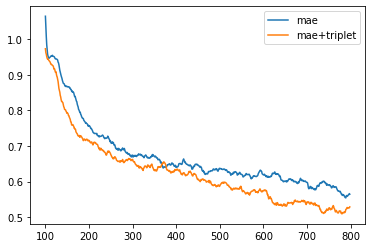

In [7]:
df2.val_rmse.to_frame(name = 'mae').join(df1.val_rmse.to_frame(name = 'mae+triplet')).rolling(20).mean().iloc[100:].plot()

<AxesSubplot:>

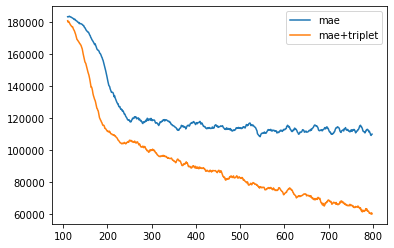

In [8]:
df2.triplets.to_frame(name = 'mae').join(df1.triplets.to_frame(name = 'mae+triplet')).rolling(10).mean().iloc[110:].plot()